# <center> Udacity Data Analyst Nanodegree, Project 2 </center>
## Exploring The Baseball Dataset

In this analysis, I have chosen to examine variations in hitting performance as measured by the statistics found in the "Batting" table in the dataset.  I use 3 metrics of hitting effectiveness: batting average, total home runs, and slugging percentage.  

For a univariate analysis, I examine the frequency distribution of batting averages in the cleaned batting table.  Exploring the reason for the skewed appearance of the distribution helps to refine the dataset used for the multivariate analyses.  

For the multivariate analyses, variations in these statistics are examined for correlation in three ways:
1.  What is the relationship between indivivdual hitting leaders and team performance?  The individual season leaders in the 3 hitting measures are identified.  Team success, as measured by divison rank, league championship, and World Series wins, is correlated with having the individual hitting champions on the team.
2.  How has hitting performance varied over the history of major league baseball?  Changes in batting average and slugging percentages are correlated with some significant changes in the rules of professional baseball.  Differences before and after changes are tested for statistical significance.
3.  Where do the power hitters usually play on a team?  Means of individual batting averages and slugging percentages are calculated for each fielding position across seasons.  To allow valid comparisons across different years, these measures are normalized by converting to z-scores using means and standard deviations for each season.  The z-scores for each position are plotted against time, and the plots are examined for trends.

## Cleaning up the batting table
On first scanning the batting table, I saw that there were NaN's in several columns.  They appeared to be only in columns for statistics which were not recorded in the early years of professional baseball.  Since I was planning to limit my analysis to statistics using only at-bats and the columns for hits of various types, I was not too worried about this.  Scanning the first and the last few years of the table showed no NaN's in these basic data columns.  However, when I checked using the "isnull()" function, there were in fact about 5,000 rows (out of about 90,000) where NaN was found in these basic columns.  With NaN in at-bats, these rows could not be used for calculating any hitting statistics.  I therefore used the Pandas df.dropna() method to remove these rows from the table.  Further checking showed no NaN's in the various identifying columns: playerID, yearID, etc.  The table index was reset to insure the following clean-up step would work properly.

Further examination of the batting table shows a major problem for its use in calculating individual hitting statistics.  In any one year there may be more than one row for each player.  Each of these represents a separate "stint" during the season, typically playing with a different team.  Since a player's batting average, etc., for the season is based on all plate appearnces during the season, all of a player's data for a season need to be combined into one row in the table.  Additionally, the player's team affiliation for the season should be the team with which he had the most appearances.  Therefore, the batting table was processed to add all at-bats, hits, etc. together in any season when a player had more than one stint in the majors.  Also, the team (and league) with which the player appeared most often was identified and inserted into the data row with the combined hitting statistics.  As doing this involved individual row-by-row comparisons, I was unable to figure out an algorithm which did not use the "iterrows()" method, which is quite inefficient.  The clean-up script took about 4 minutes to run on my computer, so I saved the file to disk and reloaded that file into this notebook for further processing.  

Two additional steps were used in the cleanup process. The first was to drop all rows prior to the 1901 season.  I did this because the rules for baseball were not really standardized until 1900, so prior year statistics could be based on a game in which it took 8 balls to get a walk, a foul ball did not count as a strike, etc.!  The second was to drop all rows with 0 at-bats, as calculating batting average for these rows would result in a divide-by-zero condition and a NaN in the result.

The code for the batting table cleanup is included in a separate notebook, creatively named "Clean Up Batting Table".

In [1]:
## import required modules and tables
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats

%matplotlib inline

## set file location for files:
df_dir = 'c:/users/roke/documents/udacity/udacity nanodegree/project 2/Baseball_Data_Tables/'

## load the batting table in which all stints for a season have been combined, and player's
## team ID and leagueID have been set to the team and league with which the player appeared
## in the most games.
df_batting = pd.read_csv(df_dir + 'Batting_Modern_TL_Fixed.csv')
## load other tables needed for analyses
## Master table has players' names and other information:
df_players = pd.read_csv(df_dir + 'master.csv')
## Teams table has info on record, standing, and whether championship(s) won:
df_teams = pd.read_csv(df_dir + 'Teams.csv')
## check what batting table looks like
df_batting.head()


,playerID,yearID,teamID,lgID,G,AB,R,H,2B,3B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,anderjo01,1901,MLA,AL,138,576.0,90.0,190.0,46.0,7.0,...,99.0,35.0,NaN,24.0,NaN,NaN,3.0,4.0,NaN,NaN
1,bakerbo01,1901,CLE,AL,2,7.0,0.0,1.0,0.0,0.0,...,1.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN
2,barreji01,1901,DET,AL,135,542.0,110.0,159.0,16.0,9.0,...,65.0,26.0,NaN,76.0,NaN,NaN,5.0,7.0,NaN,NaN
3,barrysh01,1901,PHI,NL,78,292.0,38.0,69.0,12.0,0.0,...,28.0,14.0,NaN,2.0,NaN,NaN,3.0,12.0,NaN,NaN
4,bayha01,1901,CIN,NL,41,157.0,25.0,33.0,1.0,2.0,...,3.0,4.0,NaN,13.0,NaN,NaN,1.0,4.0,NaN,NaN


In [2]:
## Batting average and slugging percentage are some primary statistics needed to analyze hitting
## performance.  Compute and add to the batting table.

## Batting average is just hits divided by at-bats:

df_batting['BA'] = df_batting['H'] / df_batting['AB']

## Slugging percentage is slightly more complicated.  It is eqaul to:
##  (1B + 2*2B + 3*3B + 4*HR)/AB
##  A total for singles is not given in the table but it is equal to total
##  hits minus all the extra-base hits, or: singles = (H - 2B - 3B - HR)
##  substituting we get (H + 2B + 2*3B + 3*HR)/AB

df_batting['SLG'] = (df_batting['H'] + df_batting['2B'] + 2 * df_batting['3B']\
                     + 3 * df_batting['HR'])/df_batting['AB']

## check what it looks like
df_batting[['playerID','yearID','AB','H','BA','SLG']].head()


,playerID,yearID,AB,H,BA,SLG
0,anderjo01,1901,576.0,190.0,0.329861,0.475694
1,bakerbo01,1901,7.0,1.0,0.142857,0.142857
2,barreji01,1901,542.0,159.0,0.293358,0.378229
3,barrysh01,1901,292.0,69.0,0.236301,0.287671
4,bayha01,1901,157.0,33.0,0.210191,0.261146


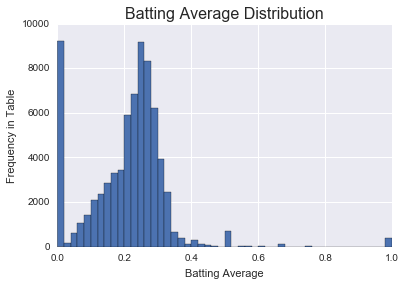

In [3]:
## Create a basic histogram showing distribution of batting averages in the table:

plt.hist(df_batting['BA'],bins=50)
plt.title('Batting Average Distribution',fontsize=16)
plt.ylabel('Frequency in Table')
plt.xlabel('Batting Average')
plt.show()

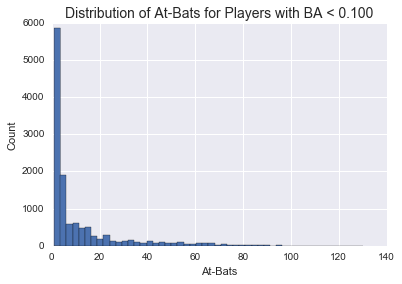

In [4]:
## The appearance of this distribution is interesting.  It is skewed to the left, but has a 
## very long tail to the right, with some players having batting averages of 1.000. 
## There are also a large number of players with an average of 0.0.  My hunch  
## is that this is caused by counting players with few, or very few, at-bats.  Check this out
## by taking a look at a histogram of at-bats for players with a batting average under 0.100.

plt.hist(df_batting[df_batting['BA'] < .100]['AB'],bins=50)
plt.title('Distribution of At-Bats for Players with BA < 0.100',fontsize=14)
plt.ylabel('Count')
plt.xlabel('At-Bats')
plt.show()

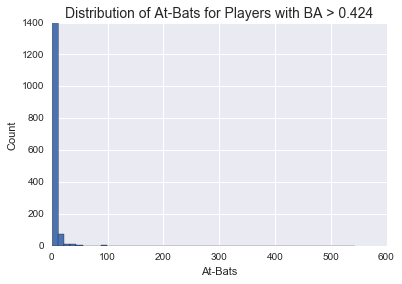

In [5]:
## We can do a similar plot for players with batting average over 0.424, which is the highest
## individual season batting average in MLB since 1901.
plt.hist(df_batting[df_batting['BA'] > 0.424 ]['AB'],bins=50)
plt.title('Distribution of At-Bats for Players with BA > 0.424',fontsize=14)
plt.ylabel('Count')
plt.xlabel('At-Bats')
plt.show()

In [68]:
## From these 2 plots it appears that essentially all players in the batting table who have
## averages inconsistent with playing a season in MLB have an at-bat total less than 100.

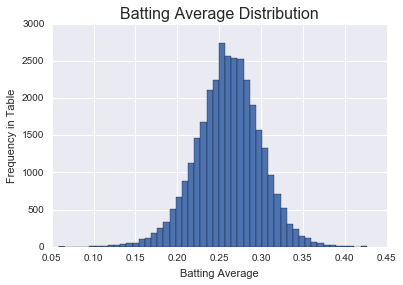

In [6]:
## To do analyses of league-leaders and other individual-based data, players with low number of
## at_bats for a season should be eliminated.  However these rows are important for calculating
## the league-wide stats, so they will be saved for easy retrieval later.
df_few_AB = df_batting[df_batting['AB']<100].copy()

df_batting = df_batting[df_batting['AB'] >= 100].reset_index(drop=True)

## take a look at the histogram now
plt.hist(df_batting['BA'],bins=50)
plt.title('Batting Average Distribution',fontsize=16)
plt.ylabel('Frequency in Table')
plt.xlabel('Batting Average')
plt.show()


Now the batting average distrubtion appears much more like a normal distribution, from which calculation of standard deviations, z-scores, etc. will make more sense.

First topic for multivariate analysis: Analyze the players who have led MLB each year in batting average,slugging percentage, and home runs.  Who are they?  How have the teams of these overall hitting champs done in their division or league standings?  

In [7]:
## Find players who led MLB overall in batting average, slugging percentage, 
## and home runs each year.  Merge info from players and teams tables as well.
def max_hit_stat(stat_name):
    df = df_batting[['yearID','playerID',stat_name,'teamID','lgID']
                     ].loc[df_batting.groupby(['yearID'])[stat_name].idxmax()]
    df = df.merge(df_players,how='left',on='playerID')\
    [['yearID','playerID',stat_name,'nameFirst','nameLast','lgID','teamID']]
    df = df.merge(df_teams[['yearID','teamID','G','W','Rank','LgWin','WSWin']],\
                                   how='left',on=['yearID','teamID'])
    return df
                                                                          
max_BA_player = max_hit_stat('BA')
max_SLG_player = max_hit_stat('SLG')
max_HR_player = max_hit_stat('HR')

## look at one of these tables to see if it looks correct:
max_BA_player.tail()


,yearID,playerID,BA,nameFirst,nameLast,lgID,teamID,G,W,Rank,LgWin,WSWin
109,2010,hamiljo03,0.359073,Josh,Hamilton,AL,TEX,162,90,1,Y,N
110,2011,cabremi01,0.344406,Miguel,Cabrera,AL,DET,162,95,1,N,N
111,2012,cabreme01,0.346405,Melky,Cabrera,NL,SFN,162,94,1,Y,Y
112,2013,cabremi01,0.347748,Miguel,Cabrera,AL,DET,162,93,1,N,N
113,2014,altuvjo01,0.340909,Jose,Altuve,AL,HOU,162,70,4,N,N


According to http://www.baseball-almanac.com/hitting/hibavg3.shtml,
this looks right, except for 2012.  Turns out Melky Cabrera was suspended in that year
for violating the league's ban on steroid use.  This dataset doesn't appear to include
information on suspensions.  Maybe something needs to be added for the current era?

In [8]:
## Now examine how the teams of these hitting champions fared during the season.  What was
## their average rank in their division (or league early on), and what fraction won their
## division, league championship, or the World Series.

## Table for each hitting title and overall mean of: standings rank, fraction division winner,
## fraction won leage, fraction who won World Series
df_team_stats_hit_champs = pd.DataFrame(data = None, columns = ['Rank','Won_div','Won_Lg','Won_WS'])

## Function to calculate mean ranking of teams with hitting champ, and the fraction of years
## when the team with the hitting leader won the division, league, or world series. Returns a 
## pandas Series, named for the hitting statistic being examined.
def get_team_stats(stat,stat_table):
    rank = stat_table['Rank'].mean()
    f_won = np.empty(3)
    ## fraction won division:
    f_won[0] = float(stat_table[stat_table['Rank']==1]['yearID'].count())/\
     len(stat_table)
    ## league champs:
    f_won[1] = float(stat_table[stat_table['LgWin']=='Y']['yearID'].count())/\
     len(stat_table)
    f_won[2] = float(stat_table[stat_table['WSWin']=='Y']['yearID'].count())/\
     len(stat_table)
    ## return Series with name stat, data
    
    return pd.Series({'Rank':rank,'Won_div':f_won[0],'Won_Lg':f_won[1],'Won_WS':f_won[2]
                     },name = stat)

## Add above stats to the dataframe for each category of overall leader: batting average,
## home runs, and slugging percentage
for stat,stat_df in [('BA',max_BA_player),('SLG',max_SLG_player),('HR',max_HR_player)]:
    df_team_stats_hit_champs = df_team_stats_hit_champs.append(get_team_stats(stat,stat_df))


print 'Average rank in standings (league or division depending on year)'
print ' for team with the overall MLB leader for:'
print '  Batting Average:', df_team_stats_hit_champs.loc['BA']['Rank']
print '  Home Runs:', df_team_stats_hit_champs.loc['HR']['Rank']
print '  Slugging Percentage:', df_team_stats_hit_champs.loc['SLG']['Rank']


Average rank in standings (league or division depending on year)
 for team with the overall MLB leader for:
  Batting Average: 3.45614035088
  Home Runs: 3.0701754386
  Slugging Percentage: 2.64035087719


So, over the history of MLB, the teams for whom the overall hitting champs played tended NOT to
be the winners in their league or division.  Although not a rigorous analysis, it suggests that
the star hitters are not of that much benefit to their teams' performance. (Although they could
boost attendance!)  Next, we look at the percentage of years since 1901 that the batting average leader's team won division title, league championship, or World Series.

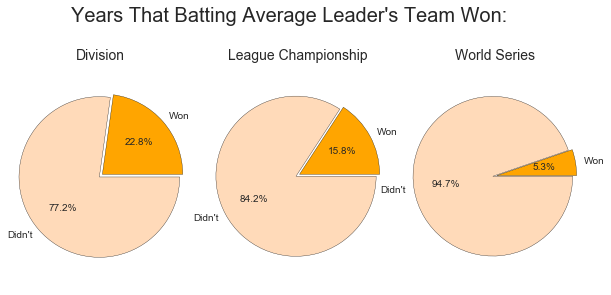

In [9]:
## Make some pie charts
labels = 'Won',"Didn't"
explode = (0.05,0)
colors = ['orange','peachpuff']

fig = plt.figure(num=1, figsize=(10,4))
fig.suptitle ("Years That Batting Average Leader's Team Won:",fontsize = 20,y=1.1)
for the_title,stat,pos in [('Division','Won_div',1),
                           ('League Championship','Won_Lg',2),('World Series','Won_WS',3)]:
    ax = plt.subplot(1,3,pos)
    ax.set_title(the_title,fontsize=14)
    won_pct = df_team_stats_hit_champs.loc['BA'][stat] * 100
    fracs = [won_pct, 100-won_pct]
    plt.pie(fracs,labels=labels,autopct='%1.1f%%',explode = explode,colors = colors)
    plt.axis('equal')

plt.show()

So it appears that having the individual leader on the team did not really correlate with the team's goal: winning their division, and ultimately, the World Series.  It's not possible to draw conclusions about causation here, but some hypotheses include: A player chasing an individual title for the year might be less of a team player.  Also, it could be easier to achieve an individual title playing for a lesser team.  Pitchers may be less worried about pitching around a good hitter if their team is already ahead by a comfortable margin, so giving up a hit is less of a concern.  Similar plots for home run leaders' and slugging leaders' teams follow.

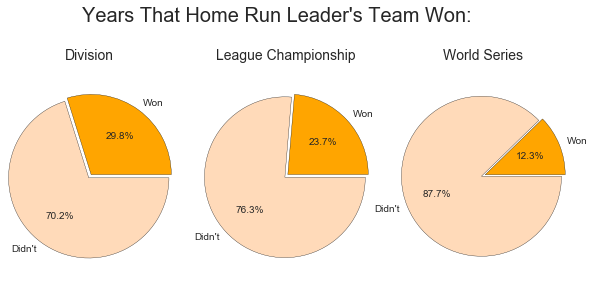

In [10]:
labels = 'Won',"Didn't"
explode = (0.05,0)
colors = ['orange','peachpuff']
fig = plt.figure(num=1, figsize=(10,4))
fig.suptitle ("Years That Home Run Leader's Team Won:",fontsize = 20,y=1.1)
for the_title,stat,pos in [('Division','Won_div',1),
                           ('League Championship','Won_Lg',2),('World Series','Won_WS',3)]:
    ax = plt.subplot(1,3,pos)
    ax.set_title(the_title,fontsize=14)
    won_pct = df_team_stats_hit_champs.loc['HR'][stat] * 100
    fracs = [won_pct, 100-won_pct]
    plt.pie(fracs,labels=labels,autopct='%1.1f%%',explode = explode,colors = colors)
    plt.axis('equal')
plt.show()

From this it looks like the home run leader's team was more likely to be division, league, or World Series winner, although it was still more often the case that he played for a team not at the top of the standings.  And finally a look at data for leader in slugging percentage:

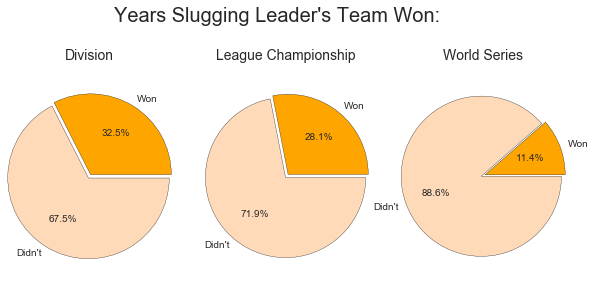

In [11]:
labels = 'Won',"Didn't"
explode = (0.05,0)
colors = ['orange','peachpuff']
fig = plt.figure(num=1, figsize=(10,4))
fig.suptitle ("Years Slugging Leader's Team Won:",fontsize = 20,y=1.1)
for the_title,stat,pos in [('Division','Won_div',1),
                           ('League Championship','Won_Lg',2),('World Series','Won_WS',3)]:
    ax = plt.subplot(1,3,pos)
    ax.set_title(the_title,fontsize=14)
    won_pct = df_team_stats_hit_champs.loc['SLG'][stat] * 100
    fracs = [won_pct, 100-won_pct]
    plt.pie(fracs,labels=labels,autopct='%1.1f%%',explode = explode,colors = colors)
    plt.axis('equal')
plt.show()

Which is pretty similar to the findings for home run leaders.

Second topic for multivariate analysis:  Examine hitting statistics over time, looking at changes across the major leagues which occurred around some significant changes in the rules of professional
baseball.  Look also at differences in hitting performance by position played, and see if these have changed over time.

In [12]:
## Calculate mean batting average, slugging percentage across baseball for each year.  Batting
## average is, by year, sum(hits)/sum(at-bats).  Add back in those players with fewer at-bats so
## the stats are accurate across all of baseball:
df_hitting_all = pd.concat([df_few_AB,df_batting])
## sum relevant columns by year
df_sum_by_year = df_hitting_all.groupby('yearID')[['AB','H','2B','3B','HR']].sum()
## add column for batting average
df_sum_by_year['BA'] = df_sum_by_year['H'] / df_sum_by_year['AB']                                                                                             
## and slugging percentage:
df_sum_by_year['SLG'] = (df_sum_by_year['H'] + df_sum_by_year['2B'] + 2 * df_sum_by_year['3B']\
                     + 3 * df_sum_by_year['HR'])/df_sum_by_year['AB']


df_sum_by_year[['BA','SLG']].tail()
## take a look at a few years just to check

,BA,SLG
yearID,,
2010,0.257352,0.402841
2011,0.255074,0.399010
2012,0.254540,0.405323
2013,0.253465,0.396471
2014,0.251156,0.386368


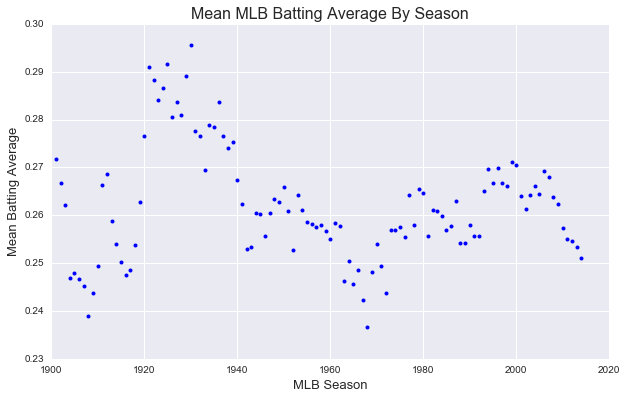

In [13]:
## And according to http:www.baseball-reference.com, these numbers are correct.
## Begin looking at trends over time.  First, plot mean overall MLB batting average by season.

plt.figure(num = 1,figsize = (10,6))
plt.plot(df_sum_by_year.index,df_sum_by_year['BA'],'bo',ms=4.0)
plt.xlabel('MLB Season',size = 13)
plt.ylabel('Mean Batting Average',size = 13)
plt.title('Mean MLB Batting Average By Season',size  = 16)

plt.show()


This plot appears to show some significant ups and downs over time.  Next smooth it a bit and
add some markers indicating key events which might have influenced these data.

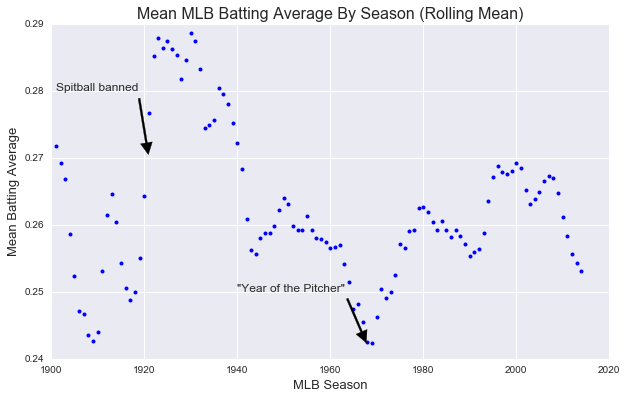

In [14]:
## create a rolling mean dataframe for the yearly means with 3-year window:

df_rm = pd.rolling_mean(df_sum_by_year[['BA','SLG']],window = 3, min_periods = 1) 

## and have a look at the plot for batting average with a couple of key rule changes 
## annotated

plt.figure(num = 1,figsize = (10,6))
plt.plot(df_rm.index,df_rm['BA'],'bo',ms=4.0)
plt.xlabel('MLB Season',size = 13)
plt.ylabel('Mean Batting Average',size = 13)
plt.title('Mean MLB Batting Average By Season (Rolling Mean)',size  = 16)
plt.annotate('Spitball banned',xy = (1921,0.27),xytext = (1901,0.28), \
             arrowprops = dict(facecolor='black',shrink=0.05,width = 2.0),size = 12)
plt.annotate('"Year of the Pitcher"',xy=(1968,0.242),xytext = (1940,0.25),\
            arrowprops = dict(facecolor='black',shrink=0.05,width = 2.0), size = 12)
plt.show()

The arrows indicate when some significant rule changes took place:

Prior to 1920-21, players were allowed to apply all manner of foreign substances to the baseball to make it harder to see.  In addition, the ball was used until it became truly unplayable. As a result, it became progressively softer and harder to hit effectively.  In 1920, a player was struck in the head by a pitched ball and died as a result of his injuries.  In response, during the following offseason, applying foreign substances to the ball was made illegal (banning the spitball).  Also, umpires were required to introduce new, clean, white balls into play regularly.

In the early 1960's, pitchers seemed to increasingly gain the upper hand in the game.  The culmination of this trend was in 1968, known as the "Year of the Pitcher".  Overall runs scored were at an all-time low, and fans did not seem to appreciate games without so little offense.  After the 1968 season, two changes were made:  the size of the strike zone was reduced, and the pitching mound was lowered.  

The plot above does appears to show an increase in batting averages after the spitball was banned.  It also looks as if there was an increase, although not as sudden, after the changes made in response to the pitchers' dominance in the 1960's.  

We'll take a look at a plot of slugging percentage also, then do a statistical analysis of batting
average changes around the rule change dates noted above.

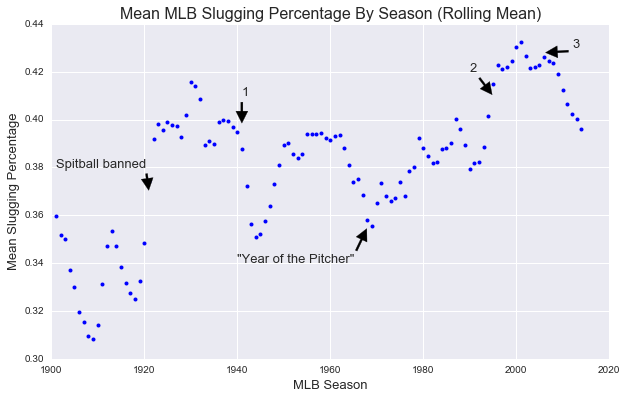

In [15]:
## Do the same plot for slugging average, add a few more markers of interest

fig = plt.figure(num = 1,figsize = (10,6))
plt.plot(df_rm.index,df_rm['SLG'],'bo',ms=4.0)
plt.xlabel('MLB Season',size = 13)
plt.ylabel('Mean Slugging Percentage',size = 13)
plt.title('Mean MLB Slugging Percentage By Season (Rolling Mean)',size  = 16)
plt.annotate('Spitball banned',xy = (1921,0.37),xytext = (1901,0.38), \
             arrowprops = dict(facecolor='black',shrink=0.05,width = 2.0),size = 13)
plt.annotate('"Year of the Pitcher"',xy=(1968,0.355),xytext = (1940,0.34),\
            arrowprops = dict(facecolor='black',shrink=0.05,width = 2.0), size = 13)
plt.annotate('1',xy=(1941,0.398),xytext=(1941,0.41),\
             arrowprops = dict(facecolor='black',shrink=0.05,width = 2.0), size = 13)
plt.annotate('2',xy=(1995,0.41),xytext=(1990,0.420),\
             arrowprops = dict(facecolor='black',shrink=0.05,width = 2.0), size = 13)
plt.annotate('3',xy=(2006,0.428),xytext=(2012,0.43),\
            arrowprops = dict(facecolor='black',shrink=0.05,width = 2.0), size = 13)
plt.show()


Slugging percentage, reflecting extra base hits (doubles, triples home runs), shows similar changes to batting averages at the points already discussed.  There are a few other trends which look interesting in this plot.  

In the early 1940's ("1" in the figure) there is a drop in slugging percentage which occurred when many professional players left the game for military service.  Those who continued to play in the major leagues either had physical ailments making them unsuitable for military service, or came from minor league or foreign teams.  There is a comparable rebound after about 1945.  Interestingly, in the batting average plot, there is a dip around the start of WWII, but no rebound similar to the slugging numbers.

There is also what looks like a significant rise in the late 1990's ("2" in the figure), which continued through the early 2000's.  During this time, slugging percentages were higher that at any other point in MLB history.  This era is probably when steroid use became widespread, and it's end ("3" in the figure) corresponds to the time MLB instituted rigorous testing and significant penalties for violations.  Both batting averages and slugging seem to again be on a downward trend.  Who knows what comes next?

These are, however, impressions based on the visual appearance of these plots.  What happens if we look at some statistical tests of significance?  If hitting statistics for the same players are examined before and after a rule change, that should help control for possible confounding variables which could affect results.  For such a comparison, the correlated sample t-statistic should be appropriate.

In [16]:
## Function to return means of a requested stat for all players active during all years of a given
## interval before and after a specific year.  The input table should have columns named 'yearID' 
## and 'playerID', as well as one named for the statistic of interest.  Also, the input table 
## is assumed to have at most one row for each player active during a given year.

def stats_before_after(change_year, before_after, df_stats, stat_name):
    ## change_year will be assumed to be the FIRST year included in the "after" group
    ## before_after is the number of years before and after this year to include
    start_year = change_year - before_after
    end_year = change_year + before_after - 1
    ## This dataframe will have all records for the years of interest:
    the_query = '(yearID >=' + str(start_year) +') & (yearID <=' + str(end_year) + ')'
    df_interval = df_stats.query(the_query)

    ## But we want to limit it to players who were active for ALL years in the intetrval.  
    ## Get the names of all unique player ID's in the table
    ar_players_names = df_interval['playerID'].unique()

    ## Create a dataframe which will be used to 
    ## hold the data just of players of interest:
    df_players_all_years = pd.DataFrame(data = None,columns = df_interval.columns)

    ## Populate with the appropriate rows from the larger table:
    for player in ar_players_names:
        df_sub = df_interval[df_interval['playerID'] == player]
        if len(df_sub) == 2 * before_after:
            df_players_all_years = pd.concat([df_players_all_years,df_sub])
            
    ## Split into the periods before and after year of interest
    the_query = '(yearID >=' + str(start_year) + ')&(yearID  < ' + str(change_year) + ')'
    df_before = df_players_all_years.query(the_query)
    
    the_query = '(yearID >=' + str(change_year) + ')&(yearID <=' + str(end_year) + ')'
    df_after = df_players_all_years.query(the_query)
    
    ##  noe create a dataframe holding mean of the stat of interest 
    ## for each player before and after the year of interest
    df_bef_aft_year = pd.Series.to_frame(df_before.groupby('playerID')[stat_name].mean())
    df_bef_aft_year = df_bef_aft_year.rename(columns = ({stat_name : stat_name + '_Before'}))
    df_bef_aft_year[stat_name +'_After'] = df_after.groupby('playerID')[stat_name].mean()

    ## Compute the difference in the "Before" and "After" conditions:
    df_bef_aft_year[stat_name +'_diff'] = df_bef_aft_year['BA_After'] - \
        df_bef_aft_year['BA_Before'] 
    
    return df_bef_aft_year


In [17]:
## First examine batting averages for the period around the time the spitball rule was changed.
## Get the data for the interval of interest.  This analysis uses players with 

df_bef_aft_spitball = stats_before_after(1921,3,df_batting,'BA')
t,p = stats.ttest_1samp(df_bef_aft_spitball['BA_diff'],0)
print 'For this analysis, the null hypothesis is that there is no change in hitting as'
print 'measured by batting average after the spitball rule change.  The alternate'
print 'hypothesis is that there was a significant increase in the batting average'
print 'following the rule change.'
print 'Correlateed t-test for BA before and after spitball rule change:'
print '  t = ',t, 'p =', p, 'DF =',len(df_bef_aft_spitball)-1
print '(This p value is based on a 2-tailed test, so would be approximately twice this'
print 'value for the one-tailed hypothesis above.)'

For this analysis, the null hypothesis is that there is no change in hitting as
measured by batting average after the spitball rule change.  The alternate
hypothesis is that there was a significant increase in the batting average
following the rule change.
Correlateed t-test for BA before and after spitball rule change:
  t =  6.89045816265 p = 3.57313382258e-09 DF = 61
(This p value is based on a 2-tailed test, so would be approximately twice this
value for the one-tailed hypothesis above.)


With a T-statistic of 6.89 and a P << .0001, we can say there was indeed a significant change (increase) in batting averages for these hitters after the 1920-1921 off-season, when the rule change described above was instituted.  This suggests, but does not prove, that the change in
batting average occurred as a result of the rule changes of 1921.

In [18]:
## Now look at batting average for 3 years before and after the pitching mound and strike zone
## rule changes of 1969
df_bef_aft_YOP = stats_before_after(1969,3,df_batting,'BA')
t,p = stats.ttest_1samp(df_bef_aft_YOP['BA_diff'],0)
print "Correlated t-test for BA before and after changes in 1969: reduced strike zone,"
print "lowered pitcher's mound:"
print '   t =,',t, 'p =',p, 'DF =',len(df_bef_aft_YOP)

Correlated t-test for BA before and after changes in 1969: reduced strike zone,
lowered pitcher's mound:
   t =, 3.65364197913 p = 0.000397776775598 DF = 111


Which, although not as large as the change around the spitball rule change, also appears to be a
a significant result when exmained in this way (p < 0.001).  Again, this doesn't prove that the
changes of 1969 caused an increase in hitting.  However, that was the intent of MLB management, 
and the outcome was in the desired direction in a statistically significant way.

Now for a third multivariate analysis, look to see if there are significant difference in hitting, as measured by batting average and slugging percentage, based on the position played on defense.

In [19]:
## First, add to the batting table the primary position played by that hitter 
## during each season.  This information isn't given specifically in the batting dataset.  

## However there is a table giving the number of games in which an individual played a
## certain defensive position.  
## Load the table of player's appearances during each season:
df_app = pd.read_csv(df_dir + 'Appearances.csv')

## It is possible to find the position at which each player appeared the maximum number of games.
## Define a new column called "max_g_at" which is the position played for the most games that year:
df_app['max_g_at']=df_app[['G_p','G_c','G_1b','G_2b','G_3b','G_ss','G_lf','G_cf','G_rf']]\
    .idxmax(axis=1)
    
## The values in the mag_g_at column are a little cryptic. For ease of use later on convert them to
## more standard abbreviations: P, C, 1B, etc.
convert_pos = {
    'G_p' : 'P',
    'G_c' : 'C',
    'G_1b' : '1B',
    'G_2b' : '2B',
    'G_3b' : '3B',
    'G_ss' : 'SS',
    'G_lf' : 'LF',
    'G_cf' : 'CF',
    'G_rf' : 'RF',
    'G_dh' : 'DH'
}

df_app['POS'] = df_app['max_g_at'].map(convert_pos)
## Check how this looks
df_app.tail(10)

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,...,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,max_g_at,POS
99456,2014,TEX,AL,saundjo01,14,8,0,14,14,0,...,0,0,0,0,0,0,0,0,G_p,P
99457,2014,DET,AL,smylydr01,28,25,1,28,28,0,...,0,0,0,0,0,0,0,0,G_p,P
99458,2014,NYA,AL,solarya01,131,124,131,129,0,0,...,8,7,0,0,7,0,5,0,G_3b,3B
99459,2014,TEX,AL,soriajo01,48,0,2,48,48,0,...,0,0,0,0,0,0,0,0,G_p,P
99460,2014,OAK,AL,straida01,14,8,6,14,14,0,...,0,0,0,0,0,0,0,0,G_p,P
99461,2014,SDN,NL,streehu01,61,0,30,61,61,0,...,0,0,0,0,0,0,0,0,G_p,P
99462,2014,ARI,NL,thatcjo01,53,0,33,53,53,0,...,0,0,0,0,0,0,0,0,G_p,P
99463,2014,MIA,NL,turneja01,28,18,24,28,28,0,...,0,0,0,0,0,0,0,0,G_p,P
99464,2014,WAS,NL,walteza01,62,26,62,18,0,0,...,3,6,0,2,7,20,26,2,G_lf,LF
99465,2014,HOU,AL,willije01,37,11,9,37,37,0,...,0,0,0,0,0,0,0,0,G_p,P


In [20]:
## Which looks OK.
## For each row in the batting table add the primary position played by that player that year

df_batting = df_batting.merge(df_app[['playerID','yearID','POS']],how='left',on=['playerID','yearID'])

## and have a look
df_batting.tail(20)


,playerID,yearID,teamID,lgID,G,AB,R,H,2B,3B,...,BB,SO,IBB,HBP,SH,SF,GIDP,BA,SLG,POS
35202,vicieda01,2014,CHA,AL,145,523,65,121,22,3,...,32,122,3,5,0,3,19,0.231358,0.405354,RF
35203,victosh01,2014,BOS,AL,30,123,14,33,6,1,...,6,21,0,1,1,2,3,0.268293,0.382114,RF
35204,villajo01,2014,HOU,AL,87,263,31,55,13,2,...,19,80,1,2,4,1,4,0.209125,0.353612,SS
35205,vogtst01,2014,OAK,AL,84,269,26,75,10,2,...,16,39,2,1,0,1,2,0.278810,0.431227,1B
35206,vottojo01,2014,CIN,NL,62,220,32,56,16,0,...,47,49,2,3,0,2,5,0.254545,0.409091,1B
35207,walkene01,2014,PIT,NL,137,512,74,139,25,3,...,45,88,2,11,1,2,12,0.271484,0.466797,2B
35208,walteza01,2014,WAS,NL,62,127,16,23,3,0,...,4,48,0,1,0,0,0,0.181102,0.440945,LF
35209,weeksri01,2014,MIL,NL,121,252,36,69,19,1,...,25,73,0,8,0,1,7,0.273810,0.452381,2B
35210,werthja01,2014,WAS,NL,147,534,85,156,37,1,...,83,113,3,9,0,3,9,0.292135,0.455056,RF
35211,wietema01,2014,BAL,AL,26,104,13,32,5,0,...,6,19,0,0,0,2,1,0.307692,0.500000,C


In [21]:
## Which also looks OK
## Calculate mean batting average, slugging percentage by year and position:
df_hitting_by_pos = df_batting.groupby(['yearID','POS'],as_index=False)[['BA','SLG']].mean()

## create pivot tables for each statistic
df_BA_by_pos_year = df_hitting_by_pos.pivot(index='yearID',columns='POS',values='BA')
df_SLG_by_pos_year = df_hitting_by_pos.pivot(index='yearID',columns='POS',values='SLG')

## Now we have a table for each statistic showing the mean for players in each position in
## each year.

## If we have mean and standard deviation of entire league's BA and SLG each year,then it's 
## possible to normalize the means by position by converting these z-scores for each year,
## allowing comparison across years.

## create groupby object from batting table by year
batting_gby = df_batting.groupby('yearID')
## create one dataframe each for BA and SLG with mean and std by year
df_BA_stats = batting_gby['BA'].agg({'BA_mean':np.mean,'BA_std':np.std})
df_SLG_stats = batting_gby['SLG'].agg({'SLG_mean':np.mean,'SLG_std':np.std})


## Add columns to each table for each statistic to make calculating z-score easy
df_BA_by_pos_year = df_BA_by_pos_year.merge(df_BA_stats,\
                                            how='left',left_index=True,right_index = True)

df_SLG_by_pos_year = df_SLG_by_pos_year.merge(df_SLG_stats,\
                                             how='left',left_index = True,right_index = True)
## take a look at one to check it
df_BA_by_pos_year.tail()

POS,1B,2B,3B,C,CF,LF,P,RF,SS,BA_std,BA_mean
yearID,,,,,,,,,,,
2010,0.256729,0.260755,0.252149,0.242627,0.259441,0.253946,0.277628,0.259558,0.256316,0.033116,0.255022
2011,0.258182,0.256813,0.248722,0.240271,0.254169,0.251953,0.261123,0.264173,0.253316,0.035818,0.252972
2012,0.253717,0.250291,0.259511,0.240894,0.259297,0.254322,0.228311,0.260206,0.248906,0.035572,0.253034
2013,0.253863,0.251098,0.248995,0.236552,0.252961,0.247481,0.201328,0.259513,0.250102,0.035805,0.249315
2014,0.248828,0.246627,0.255023,0.241120,0.259453,0.244299,NaN,0.255881,0.248050,0.036357,0.249392


In [22]:
## Drop pitchers from the analysis for now
df_SLG_by_pos_year.drop('P',axis=1,inplace=True)
df_BA_by_pos_year.drop('P',axis=1,inplace=True)

# Add columns with the z score for each position
for col_name in ['1B','2B','3B','C','CF','LF','RF','SS']:
    df_SLG_by_pos_year[col_name + 'z'] = \
    (df_SLG_by_pos_year[col_name] - df_SLG_by_pos_year['SLG_mean']) / df_SLG_by_pos_year['SLG_std']
    df_BA_by_pos_year[col_name + 'z'] = \
    (df_BA_by_pos_year[col_name] - df_BA_by_pos_year['BA_mean']) / df_BA_by_pos_year['BA_std']


In [23]:
df_SLG_by_pos_year.head()


POS,1B,2B,3B,C,CF,LF,RF,SS,SLG_std,SLG_mean,1Bz,2Bz,3Bz,Cz,CFz,LFz,RFz,SSz
yearID,,,,,,,,,,,,,,,,,,
1901,0.377010,0.341207,0.359154,0.328147,0.369266,0.383489,0.379515,0.335337,0.084692,0.339867,0.438556,0.015813,0.227723,-0.138383,0.347119,0.515062,0.468130,-0.053489
1902,0.351007,0.349588,0.344929,0.307673,0.374600,0.368596,0.372327,0.324033,0.080516,0.334942,0.199515,0.181892,0.124028,-0.338682,0.492547,0.417974,0.464313,-0.135497
1903,0.351619,0.330127,0.370006,0.300057,0.355196,0.387709,0.359614,0.323973,0.078680,0.328370,0.295488,0.022328,0.529177,-0.359845,0.340953,0.754181,0.397104,-0.055882
1904,0.337632,0.316282,0.307073,0.285689,0.345720,0.354442,0.337304,0.320207,0.072303,0.310019,0.381917,0.086634,-0.040742,-0.336493,0.493784,0.614411,0.377377,0.140918
1905,0.344713,0.320921,0.306125,0.285181,0.350345,0.341766,0.357798,0.318693,0.069099,0.314307,0.440042,0.095727,-0.118408,-0.421509,0.521543,0.397390,0.629401,0.063479


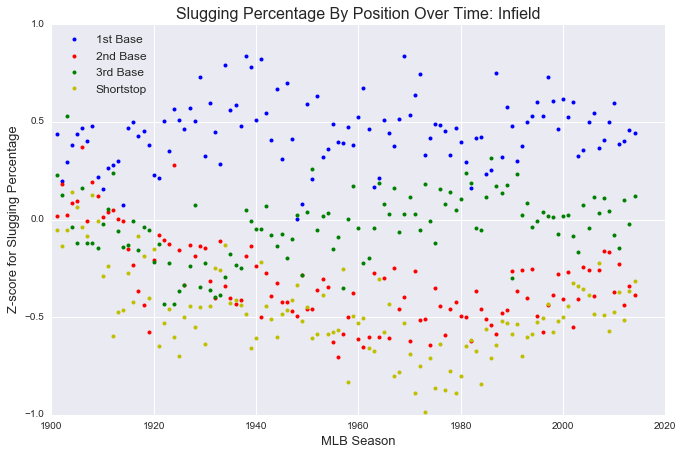

In [24]:
## Plot slugging z-score for different infield positions over time
fig = plt.figure(num = 1,figsize = (11,7))
for (col,mkr,lbl) in [('1Bz','bo','1st Base'),('2Bz','ro','2nd Base'),\
                      ('3Bz','go','3rd Base'),('SSz','yo','Shortstop')]:
    plt.plot(df_SLG_by_pos_year.index,df_SLG_by_pos_year[col],mkr,ms=4.0,label=lbl)
plt.xlabel ('MLB Season',size=13)
plt.ylabel ('Z-score for Slugging Percentage',size=13)
plt.title ('Slugging Percentage By Position Over Time: Infield',size = 16)
plt.legend (loc='upper left',fontsize='large')
plt.show()


So it looks like before about 1920, there was little difference in slugging power between infielders.  After 1920, the first basemen emerged as the power hitters and remained that way.  After about 1940, the third basemen started to occupy a middle position betweewn the first basemen and other infielders as sluggers.  The shortstops and second basemen remained about the same at the lower range of long ball hitters.

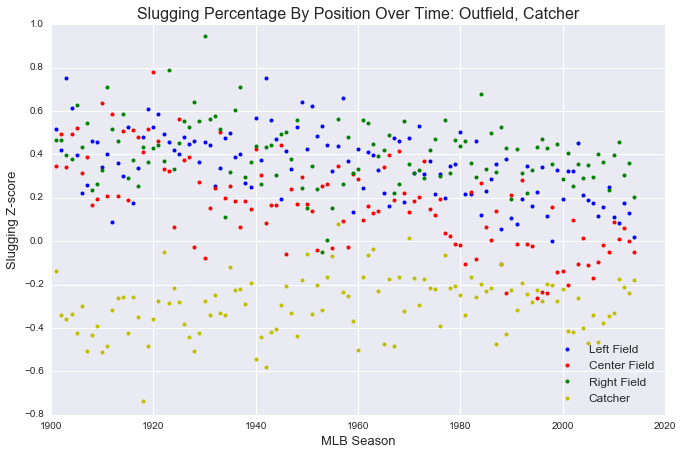

In [25]:
fig = plt.figure(num = 1,figsize = (11,7))
for (col,mkr,lbl) in [('LFz','bo','Left Field'),('CFz','ro','Center Field'),\
                      ('RFz','go','Right Field'),('Cz','yo','Catcher')]:
    plt.plot(df_SLG_by_pos_year.index,df_SLG_by_pos_year[col],mkr,ms=4.0,label=lbl)
plt.title('Slugging Percentage By Position Over Time: Outfield, Catcher',size=16)
plt.ylabel('Slugging Z-score',size=13)
plt.xlabel('MLB Season',size=13)
plt.legend (loc='lower right',fontsize='large')
plt.show()


In this plot, it looks like the outfielders are pretty similar, with perhaps a slight overall downward trend over time. In recent years the center fielders seem to have separated out as a group slightly lower than right- and left-fielders. Catchers remain below the mean for slugging throughout.

## Conclusions:
1.  The frequency distribution of batting average in the complete, cleaned Batting table is skewed by inclusion of players with very few at-bats.  Dropping players with less than 100 at-bats in a season results in a distribution which more closely resembles a normal one.  (This conclusion is based on visual appearance only and I did not subject it to any statistical testing).
2.  Teams whose roster included a season leader in hitting performance were typically middle of the pack in ranking.  Having a hitting leader was not strongly correlated with success in winning a league championship or the world series.  It is important to note that this conclusion says nothing about causation.  A player pursuing a hitting title could be a distraction for a team (like Barry Bonds seemed to be at times for the SF Giants), or his salary could eat up too much of the club payroll to allow for a more competitive roster.  Or it could be easier for a player to achieve better stats when playing for a mediocre team.  
3.  Major changes in the rules of baseball are correlated with statistically significant changes in hitting performance.  Two examples are the rule change banning the spitball in 1921, and changes to the strike zone and pitching mound height in 1968.  Additional correlations identiifed on the basis of visual appearance in plots include the onset and end of World War II, and the beginning and end of the "steroid era" in modern baseball.  The trends noted around these other events are based on visual inspection only, and have not been subjected to statistical testing.
4.  Differences in positions played by power hitters appear to have evolved over time.  Early in the history of baseball (1900-1920) there appears to have been little diffeerence.  In the modern era, first basemen and the corner outfielders seem to be the power hitters, and shortstops and catchers typically lag behind the mean in slugging power.  Again, these conclusions are based on visual inspection of the relevant plots, and should therefore be regarded as tentative pending more rigorous analysis.

### References:
1.  Baseball history web sites were used to research the rule changes discussed in section 2.  Baseball data web sites were used to verify the correctness of my calculations of season batting averages and slugging percentages.
2.  Stack Overflow was used for answers to individual programming questions I encountered.  
3.  Stack Overflow was also used to look up specific questions about the Matplotlib plots I used, such as how to position titles on the pie charts.